# 02456 Deep Learning - Acne Vulgaris vs Acne Rosacea

# Train last layer of Inception

__Note__ the best performance was *not* obtained by this Keras implementation, but the Google implementation, which is linked in the references. In theory they should be the same, but the Keras implementation is not performing as good. In the report the google implementation is marked as the best performing model, and can be tested using the notebook "Evaluate_model_retrain.ipynb" which uses the best model (And therefore not this model). 

This notebook is just to show how to train a Keras implementation of the Inception V3 Model, if you want to evaluate some of your own images, use the Evaluate notebooks, which contains already trained networks. 

### Model: Retrain last layer of Inception V3 - Using Keras

Authors:
* s134859 Nicolai Mogensen
* s134569 Tobias Slot Jensen
* s144242 David Frich Hansen

References:
* The Google Transfer Learning implementation: https://www.tensorflow.org/tutorials/image_retraining

##### Network was trained using a GTX 1080 Ti. If you experience OOM errors, it is probably because the network does not fit into your memory. 

In [1]:
DIM = 299
import numpy as np
from label_image import *
import glob
import os
from pathlib import Path
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
#from PIL import Image,ImageOps
from skimage.io import imread
from skimage.transform import resize
from keras.layers import (Activation, Dense, Dropout, Flatten,
                          Lambda, MaxPooling2D)
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, model_from_json, Model
from keras.regularizers import l2
from keras.utils import np_utils
from spatial_transformer import SpatialTransformer
from keras.applications import InceptionV3
import pickle

from keras.callbacks import ModelCheckpoint,LambdaCallback,Callback
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit
import keras.backend as K

/opt/miniconda3/envs/jupyterhub/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
#Load the pickled data, this data is NOT uploaded as it is confidential
with open('images.pickle', 'rb') as handle:
    data = pickle.load(handle)


In [3]:
def conv_model(input_shape=(299, 299,3)):
  
    model = Sequential()
    model.add(Lambda(
        lambda x: x,
        input_shape=input_shape,
        output_shape=input_shape))
    
    inc_v3 = InceptionV3(include_top=False, weights='imagenet', pooling='max',classes=2)
 
    # Don't train the layers, as everything is already trained
    for layer in inc_v3.layers:
        layer.trainable = False
    
    model.add(inc_v3)
    output = Dense(2, activation='softmax')
    
    model.add(output)

    return model

In [6]:
batch_size = 64
epochs = 100
model = conv_model()

model.summary()
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [7]:
# Keras does validation splits for us, so combine the Training and Validation data, and let Keras split it. 
data["X_train_c"] = np.concatenate((data["X_train"],data["X_valid"]),axis=0)
data["y_train_c"] = np.concatenate((data["y_train"],data["y_valid"]),axis=0)

try:
    model.fit(data["X_train_c"], data["y_train_c"],
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.1,
                shuffle=True,
                callbacks=[])
                
except KeyboardInterrupt:
    print("training interrupted")


Train on 1026 samples, validate on 114 samples
Epoch 1/100
1026/1026 [==============================] - 6s - loss: 1.6729 - acc: 0.4990 - val_loss: 1.4211 - val_acc: 0.4123
Epoch 2/100
1026/1026 [==============================] - 5s - loss: 1.2547 - acc: 0.5478 - val_loss: 1.3931 - val_acc: 0.4474
Epoch 3/100
1026/1026 [==============================] - 5s - loss: 0.9403 - acc: 0.6023 - val_loss: 1.5134 - val_acc: 0.5175
Epoch 4/100
1026/1026 [==============================] - 5s - loss: 1.0253 - acc: 0.6179 - val_loss: 0.9267 - val_acc: 0.6053
Epoch 5/100
1026/1026 [==============================] - 5s - loss: 0.7187 - acc: 0.6881 - val_loss: 0.8128 - val_acc: 0.6404
Epoch 6/100
1026/1026 [==============================] - 5s - loss: 0.7162 - acc: 0.6852 - val_loss: 0.8364 - val_acc: 0.6491
Epoch 7/100
1026/1026 [==============================] - 5s - loss: 0.6715 - acc: 0.6998 - val_loss: 0.7538 - val_acc: 0.6754
Epoch 8/100
1026/1026 [==============================] - 5s - loss: 0.6

1026/1026 [==============================] - 5s - loss: 0.3818 - acc: 0.8333 - val_loss: 0.5247 - val_acc: 0.7719
Epoch 66/100
1026/1026 [==============================] - 5s - loss: 0.3464 - acc: 0.8499 - val_loss: 0.5172 - val_acc: 0.7719
Epoch 67/100
1026/1026 [==============================] - 5s - loss: 0.3637 - acc: 0.8441 - val_loss: 0.5291 - val_acc: 0.7895
Epoch 68/100
1026/1026 [==============================] - 5s - loss: 0.3962 - acc: 0.8324 - val_loss: 0.5550 - val_acc: 0.7632
Epoch 69/100
1026/1026 [==============================] - 5s - loss: 0.3887 - acc: 0.8265 - val_loss: 0.5440 - val_acc: 0.7632
Epoch 70/100
1026/1026 [==============================] - 5s - loss: 0.3477 - acc: 0.8489 - val_loss: 0.5275 - val_acc: 0.7632
Epoch 71/100
1026/1026 [==============================] - 5s - loss: 0.3223 - acc: 0.8626 - val_loss: 0.5276 - val_acc: 0.7807
Epoch 72/100
1026/1026 [==============================] - 5s - loss: 0.3565 - acc: 0.8577 - val_loss: 0.5298 - val_acc: 0.74

# Performance and AUC

In [8]:
# Evaluate model on test set
score = model.evaluate(x=data["X_test"], y=data["y_test"])
print(score)

60/60 [==============================] - 0s     
[0.50668757756551108, 0.75000000794728594]


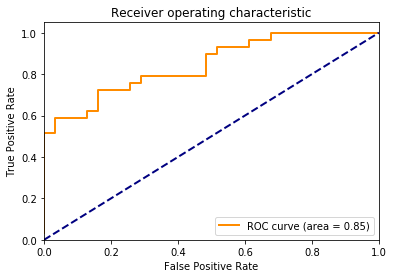

Accuracy: 0.750000007947
Specificity: 0.774193548387
Sensitivity: 0.724137931034


In [9]:
from performance_measures import *

y_prob = model.predict(data["X_test"])
y_pred = np.argmax(y_prob,axis=1)
y_true = data["y_test"]

AUC = get_roc_auc(y_true,y_prob[:,1])
accuracy = score[1]

#True Negative Rate 0,0
specificity = get_specificity(y_true,y_pred)
#True Positive Rate 1,1
sensitivity = get_sensitivity(y_true,y_pred)

print("Accuracy:",accuracy)
print("Specificity:",specificity)
print("Sensitivity:",sensitivity)

# Save Model

In [10]:
model.save('inckeras.h5') 